In [1]:
import matplotlib as mpl
from sklearn import metrics
import numpy as np
from os.path import join
import os
import pandas as pd
import re
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
from pathlib import Path
import warnings
import sys
sys.path.append("./../utilities/")
sys.path.append("./../additional_code/")
from helper_functions import *
from Binding_distribution import plot_binding_distribution
from BipartiteGraph import load_data_and_build_graph, calculate_exact_betweenness,calculate_nodes_degrees, analyze_betweenness, plot_betweenness_degrees, analyze_degree
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)
import warnings
warnings.filterwarnings("ignore")

sh: diamond: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mash: command not found
sh: foldseek: command not found
sh: TMalign: command not found


/Users/vahidatabaigi/EMMA/code
/Users/vahidatabaigi/EMMA/code


In [3]:
# Define parameters
split_methods = ['C1f', 'C1e', 'C1', 'C2']
seeds = [42, 123, 456, 789, 999]
data_dir = join("..", "data", "training_test_results")
# Calculate aggregated results
results = aggregate_results(split_methods, seeds, data_dir)
# Create tables
inter_table, sub_table = create_results_table(results, split_methods)
# Display tables
print("Interaction Head Results:")
print(inter_table.to_string(index=False))
print("\nSubclass Head Results:")
print(sub_table.to_string(index=False))

Interaction Head Results:
Split         AUROC      Accuracy            F1
  C1f 0.917 ± 0.002 0.821 ± 0.003 0.810 ± 0.004
  C1e 0.854 ± 0.005 0.755 ± 0.010 0.772 ± 0.004
   C1 0.845 ± 0.006 0.753 ± 0.006 0.726 ± 0.008
   C2 0.847 ± 0.008 0.760 ± 0.008 0.768 ± 0.017

Subclass Head Results:
Split         AUROC      Accuracy            F1
  C1f 0.991 ± 0.001 0.934 ± 0.005 0.940 ± 0.005
  C1e 0.947 ± 0.006 0.846 ± 0.011 0.878 ± 0.007
   C1 0.950 ± 0.009 0.881 ± 0.040 0.876 ± 0.047
   C2 0.954 ± 0.004 0.884 ± 0.011 0.899 ± 0.012


# Data leakage calculations 

In [4]:
df_results = pd.read_csv(join("..", "data", "splits", "EMMA_similarity_leakage_results.csv"))
df_results["train_test_TSL"]=df_results["train_test_smiles_leakage"]+ df_results["train_test_protein_leakage"]
change_name = {'C1f':'Enzyme-based','C1e':'Small molecule-based','C1':'Label-based', 'C2':'Two-dimensional'}
df_results['Split method'] = df_results['Split method'].map(change_name)
df_results

train_test_smiles_leakage  train_test_protein_leakage  \
0                      0.318                       0.011   
1                      0.279                       0.200   
2                      0.309                       0.147   
3                      0.270                       0.014   

           Split method  train_test_TSL  
0          Enzyme-based           0.329  
1  Small molecule-based           0.479  
2           Label-based           0.456  
3       Two-dimensional           0.284

In [5]:
# df_avg_results = df_results.groupby('Split method').mean().reset_index()

AUROC_Inter = {"Enzyme-based":0.917, "Small molecule-based":0.854,"Label-based":0.845, "Two-dimensional":0.847}
AUROC_Sub = {"Enzyme-based":0.991, "Small molecule-based":0.947,"Label-based":0.950, "Two-dimensional":0.954}


df_results['AUROC_Inter'] = df_results['Split method'].map(AUROC_Inter)
df_results['AUROC_Sub'] = df_results['Split method'].map(AUROC_Sub)
df_results = df_results[["Split method", "train_test_smiles_leakage", "train_test_protein_leakage", "AUROC_Inter", "AUROC_Sub"]]
df_results


desired_order = ["Enzyme-based", "Small molecule-based","Label-based", "Two-dimensional"]
df_transposed = df_results.set_index('Split method').T
df_transposed = df_transposed[desired_order]
df_transposed = df_transposed.round(3)
df_transposed


Split method                Enzyme-based  Small molecule-based  Label-based  \
train_test_smiles_leakage          0.318                 0.279        0.309   
train_test_protein_leakage         0.011                 0.200        0.147   
AUROC_Inter                        0.917                 0.854        0.845   
AUROC_Sub                          0.991                 0.947        0.950   

Split method                Two-dimensional  
train_test_smiles_leakage             0.270  
train_test_protein_leakage            0.014  
AUROC_Inter                           0.847  
AUROC_Sub                             0.954

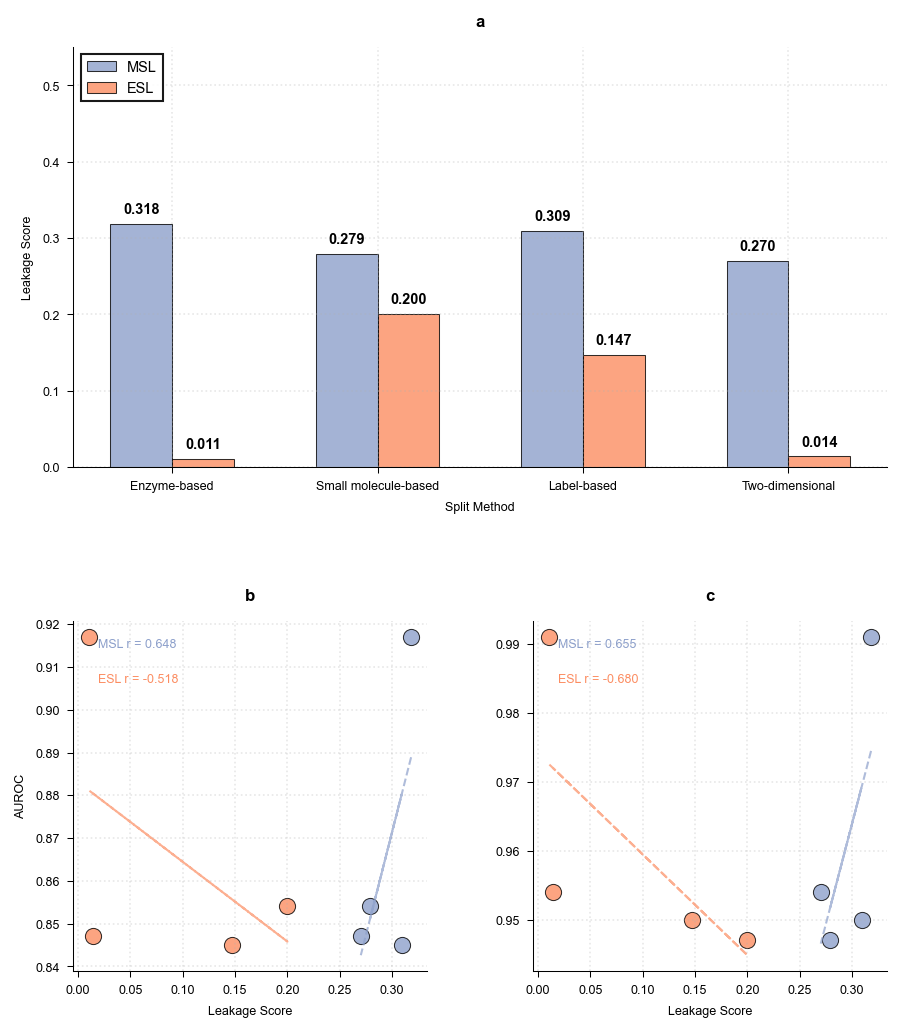

In [6]:
plot_leakage(df_results)

In [7]:
columns=["molecule_ID","Uni_SwissProt"]
splits = ["C1f", "C1e", "C1", "C2"]
leak_type=["MLSL","SLSL"]
for split in splits:
    print(f"Results for {split}")
    for column in columns:
        for leak in leak_type:
            train = pd.read_pickle(join(CURRENT_DIR, "..", "data", "splits", f"train_{split}_2S.pkl"))
            test = pd.read_pickle(join(CURRENT_DIR, "..", "data", "splits", f"test_{split}_2S.pkl"))
            train_multi = get_multi_binding(train,column,leak)
            test_multi = get_multi_binding(test,column,leak)
            shared = train_multi.intersection(test_multi)
            shared_count = len(shared)
            train_shared= train[train[column].isin(shared)]
            test_shared= train[train[column].isin(shared)]
            data_shared=pd.concat([train_shared,test_shared])
            data_shared.drop_duplicates(subset=["Uni_SwissProt", "molecule_ID", "Binding"], keep='first', inplace=True)
            print(f"{leak}:Unique {column}: {shared_count}({len(data_shared)})")

Results for C1f
MLSL:Unique molecule_ID: 467(21220)
SLSL:Unique molecule_ID: 4416(51241)
MLSL:Unique Uni_SwissProt: 0(0)
SLSL:Unique Uni_SwissProt: 0(0)
Results for C1e
MLSL:Unique molecule_ID: 0(0)
SLSL:Unique molecule_ID: 9(9)
MLSL:Unique Uni_SwissProt: 1464(61493)
SLSL:Unique Uni_SwissProt: 2734(8804)
Results for C1
MLSL:Unique molecule_ID: 341(16673)
SLSL:Unique molecule_ID: 3402(42731)
MLSL:Unique Uni_SwissProt: 94(1630)
SLSL:Unique Uni_SwissProt: 2209(15235)
Results for C2
MLSL:Unique molecule_ID: 0(0)
SLSL:Unique molecule_ID: 0(0)
MLSL:Unique Uni_SwissProt: 0(0)
SLSL:Unique Uni_SwissProt: 0(0)


In [6]:
train = pd.read_pickle(join(CURRENT_DIR, "..", "data", "splits", "train_C2_2S.pkl"))
test = pd.read_pickle(join(CURRENT_DIR, "..", "data", "splits", "test_C2_2S.pkl"))
final_dataset_C2=pd.concat([train,test])
final_dataset=pd.read_pickle(join(CURRENT_DIR, "..", "data", "processed_data", "Final_Dataset.pkl"))
columns=["Uni_SwissProt", "molecule_ID"]
for column in columns:
    # Group by 'Uni_SwissProt' and count the number of unique labels for each group
    label_counts = final_dataset.groupby(column)['Binding'].nunique()
    label_counts_C2 = final_dataset_C2.groupby(column)['Binding'].nunique()
    
    # Count how many Uni_SwissProt have 1, 2, or 3 unique labels
    single_label = (label_counts == 1).sum()
    multi_labels = (label_counts >= 2).sum()
    
    single_label_C2 = (label_counts_C2 == 1).sum()
    multi_labels_C2 = (label_counts_C2 >= 2).sum()
    
    # Total number of unique Uni_SwissProt entries
    total_uni = len(label_counts)
    total_uni_C2 = len(label_counts_C2)
    
    # Calculate percentages
    per_single_labels = (single_label / total_uni) * 100
    per_multi_labels = (multi_labels / total_uni) * 100
    
    per_single_labels_C2 = (single_label_C2 / total_uni_C2) * 100
    per_multi_labels_C2 = (multi_labels_C2 / total_uni_C2) * 100
    
    print(f"Percentage of {column} with single labels in final dataset: {per_single_labels:.2f}%")
    print(f"Percentage of {column} with multi labels in final dataset: {per_multi_labels:.2f}%")
    
    print(f"Percentage of {column} with single labels in final C2 dataset: {per_single_labels_C2:.2f}%")
    print(f"Percentage of {column} with multi labels in final C2 dataset: {per_multi_labels_C2:.2f}%")



Percentage of Uni_SwissProt with single labels in final dataset: 69.51%
Percentage of Uni_SwissProt with multi labels in final dataset: 30.49%
Percentage of Uni_SwissProt with single labels in final C2 dataset: 71.33%
Percentage of Uni_SwissProt with multi labels in final C2 dataset: 28.67%
Percentage of molecule_ID with single labels in final dataset: 93.23%
Percentage of molecule_ID with multi labels in final dataset: 6.77%
Percentage of molecule_ID with single labels in final C2 dataset: 93.62%
Percentage of molecule_ID with multi labels in final C2 dataset: 6.38%


# Degree and Betweenness Centrality 

In [2]:
CURRENT_DIR = Path(os.getcwd())
splits = ["C1f", "C1e", "C1", "C2"]
sets=["train", "test"]
for s in splits:
    for st in sets:
        path=join(CURRENT_DIR, "..", "data", "splits", f"{st}_{s}_2S.pkl")
        df= path.split("/")[-1]
        df_name=df.split(".")[0]
        print(df_name)
        B, OUTPUT_DIR = load_data_and_build_graph(path)
        degrees, duration = calculate_nodes_degrees(B)
        analyze_degree(B, degrees, OUTPUT_DIR,df_name)

train_C1f_2S
Loading data and constructing graph...
Network contains 37154 nodes and 117771 edges

CALCULATING NODE DEGREES
Degree calculation completed in 0.0062 seconds!
Total nodes: 37154

Enzyme Degree Statistics:
- Count: 12401.000000
- Mean: 9.496895
- Median: 3.000000
- Std: 26.644975
- Min: 1.000000
- Max: 358.000000
- Q1: 1.000000
- Q3: 6.000000

Molecule Degree Statistics:
- Count: 24753.000000
- Mean: 4.757848
- Median: 1.000000
- Std: 21.001648
- Min: 1.000000
- Max: 362.000000
- Q1: 1.000000
- Q3: 3.000000
test_C1f_2S
Loading data and constructing graph...
Network contains 13051 nodes and 29453 edges

CALCULATING NODE DEGREES
Degree calculation completed in 0.0020 seconds!
Total nodes: 13051

Enzyme Degree Statistics:
- Count: 3251.000000
- Mean: 9.059674
- Median: 3.000000
- Std: 25.535666
- Min: 1.000000
- Max: 418.000000
- Q1: 1.000000
- Q3: 6.000000

Molecule Degree Statistics:
- Count: 9800.000000
- Mean: 3.005408
- Median: 1.000000
- Std: 7.803889
- Min: 1.000000
- M

In [ ]:
path=join(CURRENT_DIR, "..", "data", "processed_data", "Final_Dataset.pkl")
df= path.split("/")[-1]
df_name=df.split(".")[0]
print(df_name)
B, OUTPUT_DIR = load_data_and_build_graph(path)
degrees, duration = calculate_nodes_degrees(B)
analyze_degree(B, degrees, OUTPUT_DIR,df_name)

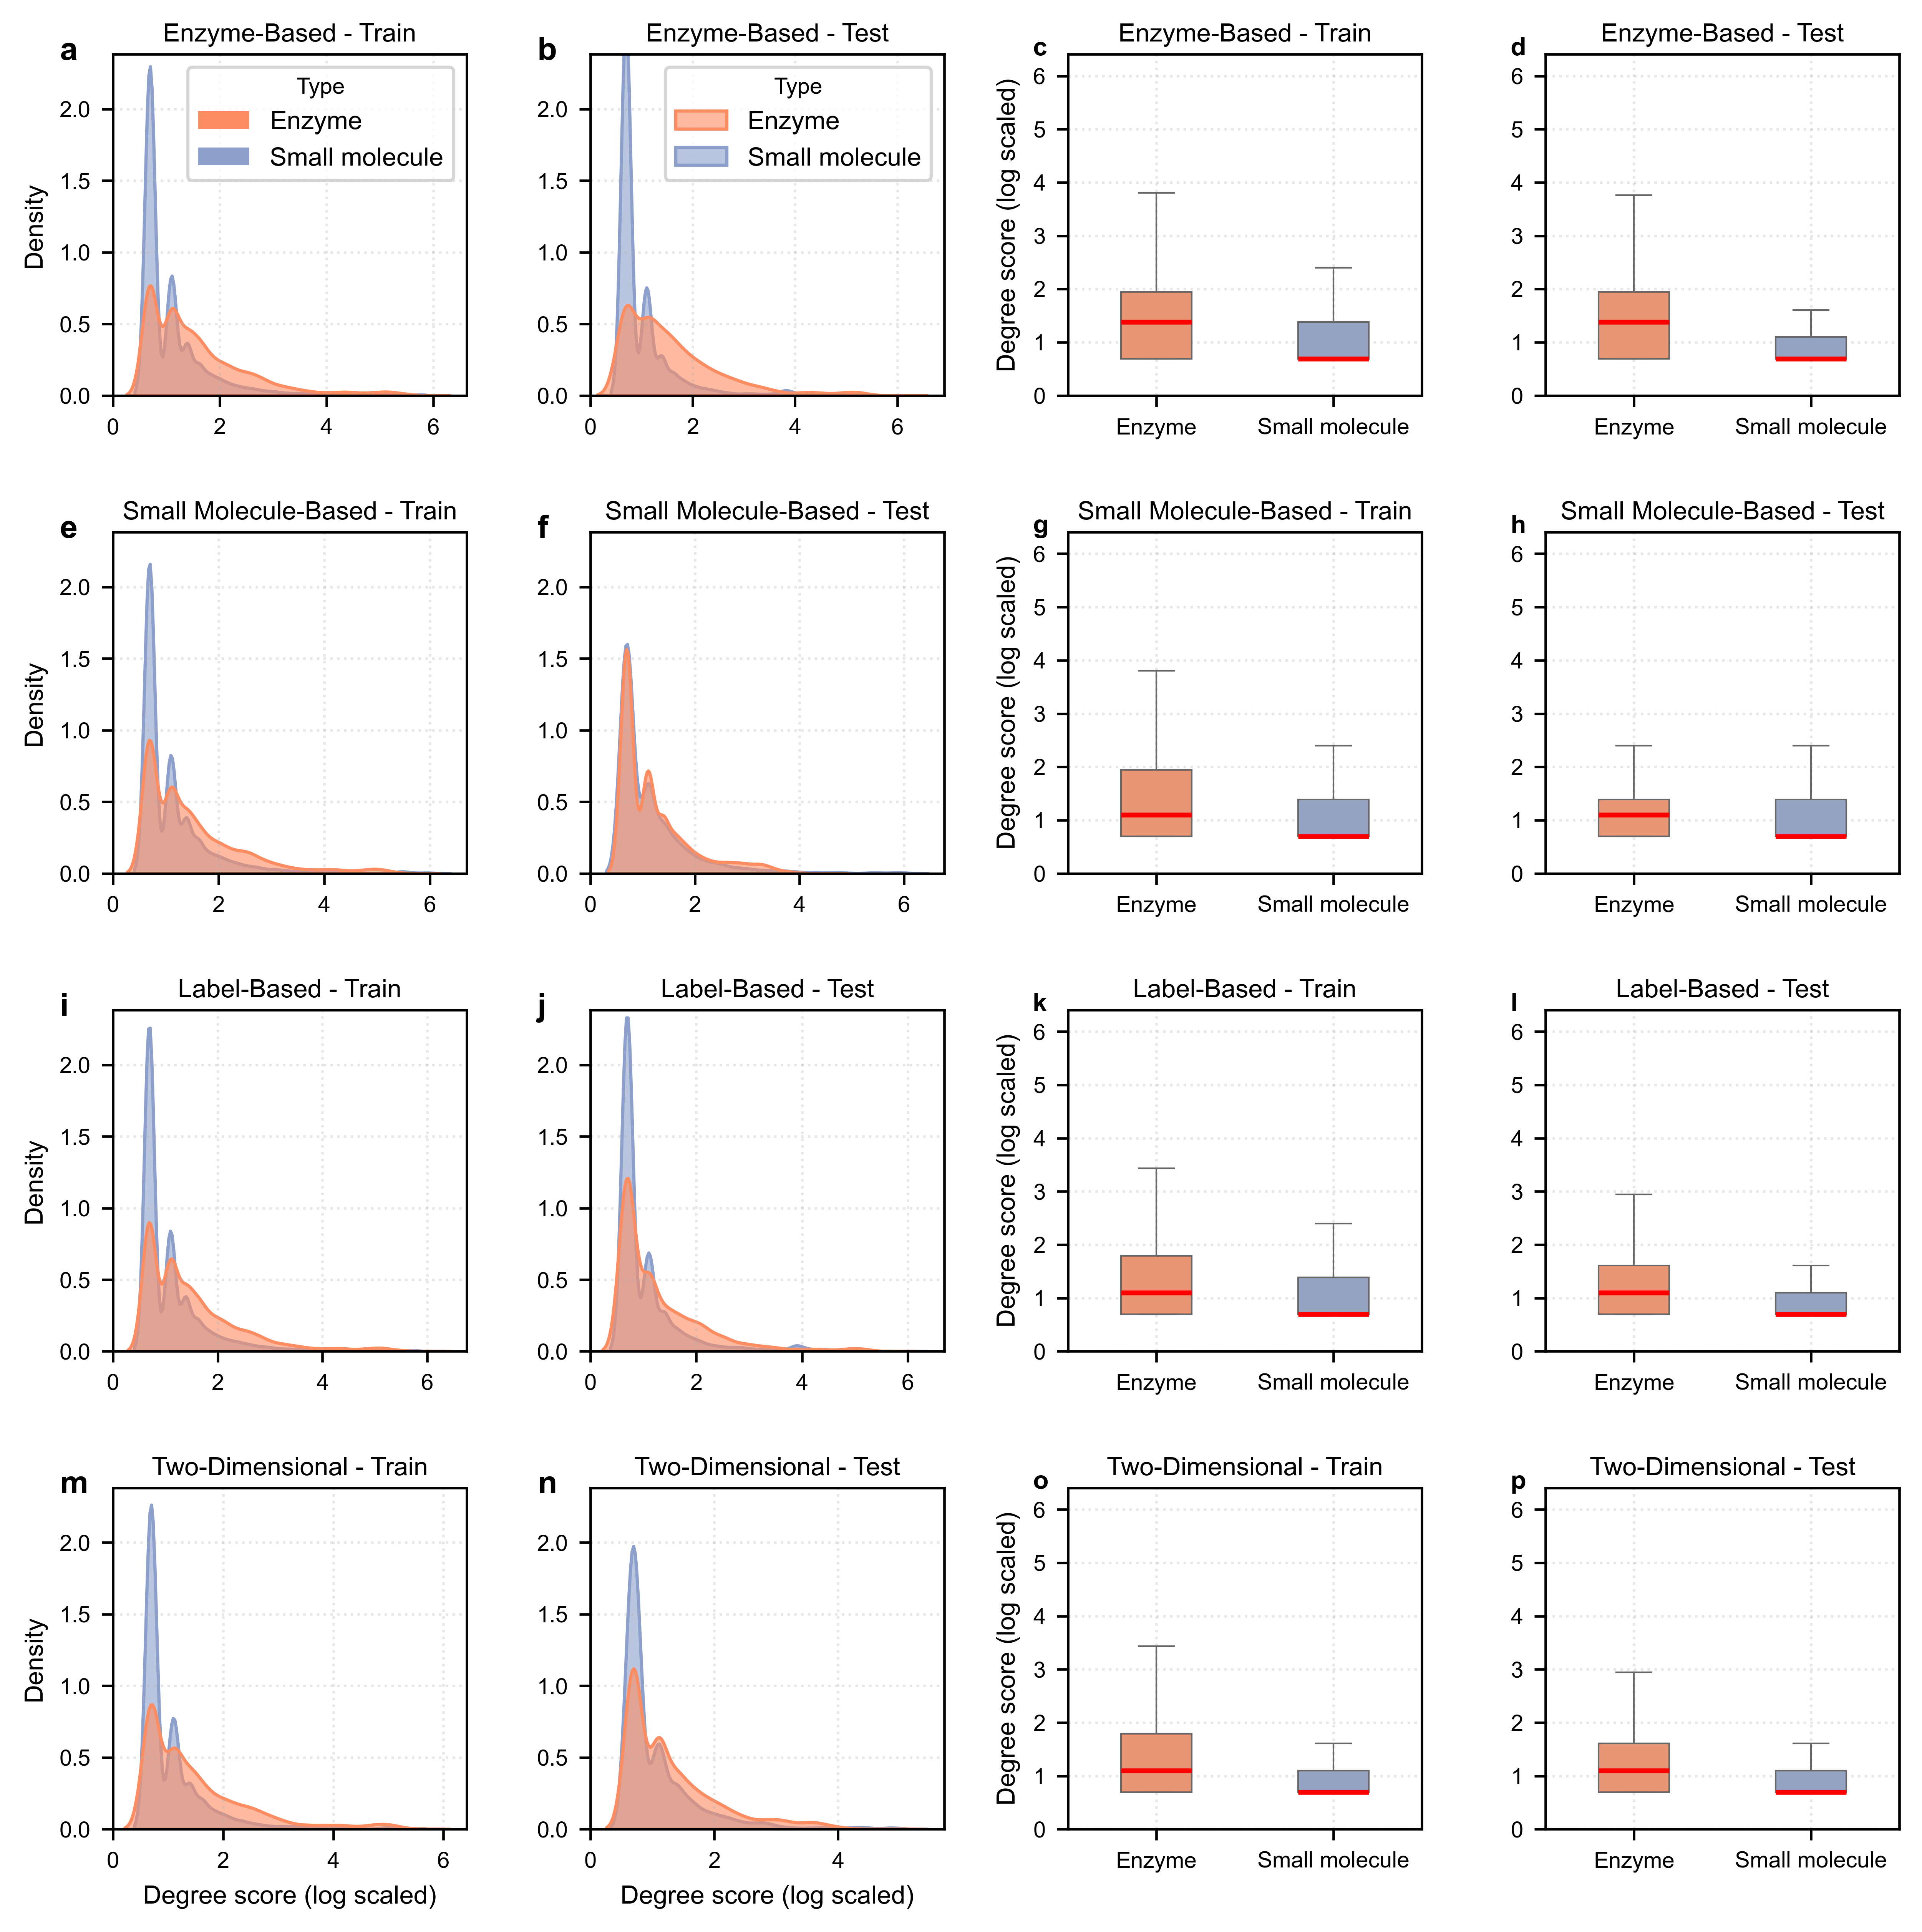

Combined analysis figure saved to: /Users/vahidatabaigi/EMMA/code/../data/final_dataset_analysis/Degree_analysis_combined.pdf


In [2]:
CURRENT_DIR = Path(os.getcwd())
OUTPUT_DIR = join(CURRENT_DIR, "..", "data", "final_dataset_analysis")
plot_betweenness_degrees(OUTPUT_DIR, metric="Degree")

In [ ]:
CURRENT_DIR = Path(os.getcwd())
splits = ["C1f", "C1e", "C1", "C2"]
sets=["train", "test"]
for s in splits:
    for st in sets:
        path=join(CURRENT_DIR, "..", "data", "splits", f"{st}_{s}_2S.pkl")
        df= path.split("/")[-1]
        df_name=df.split(".")[0]
        print(df_name)
        B, OUTPUT_DIR = load_data_and_build_graph(path)
        betweenness, duration = calculate_exact_betweenness(B)
        analyze(B, betweenness, OUTPUT_DIR,df_name)

In [ ]:
path=join(CURRENT_DIR, "..", "data", "processed_data", "Final_Dataset.pkl")
df= path.split("/")[-1]
df_name=df.split(".")[0]
print(df_name)
B, OUTPUT_DIR = load_data_and_build_graph(path)
betweenness, duration = calculate_exact_betweenness(B)
analyze_betweenness(B, betweenness, OUTPUT_DIR,df_name)

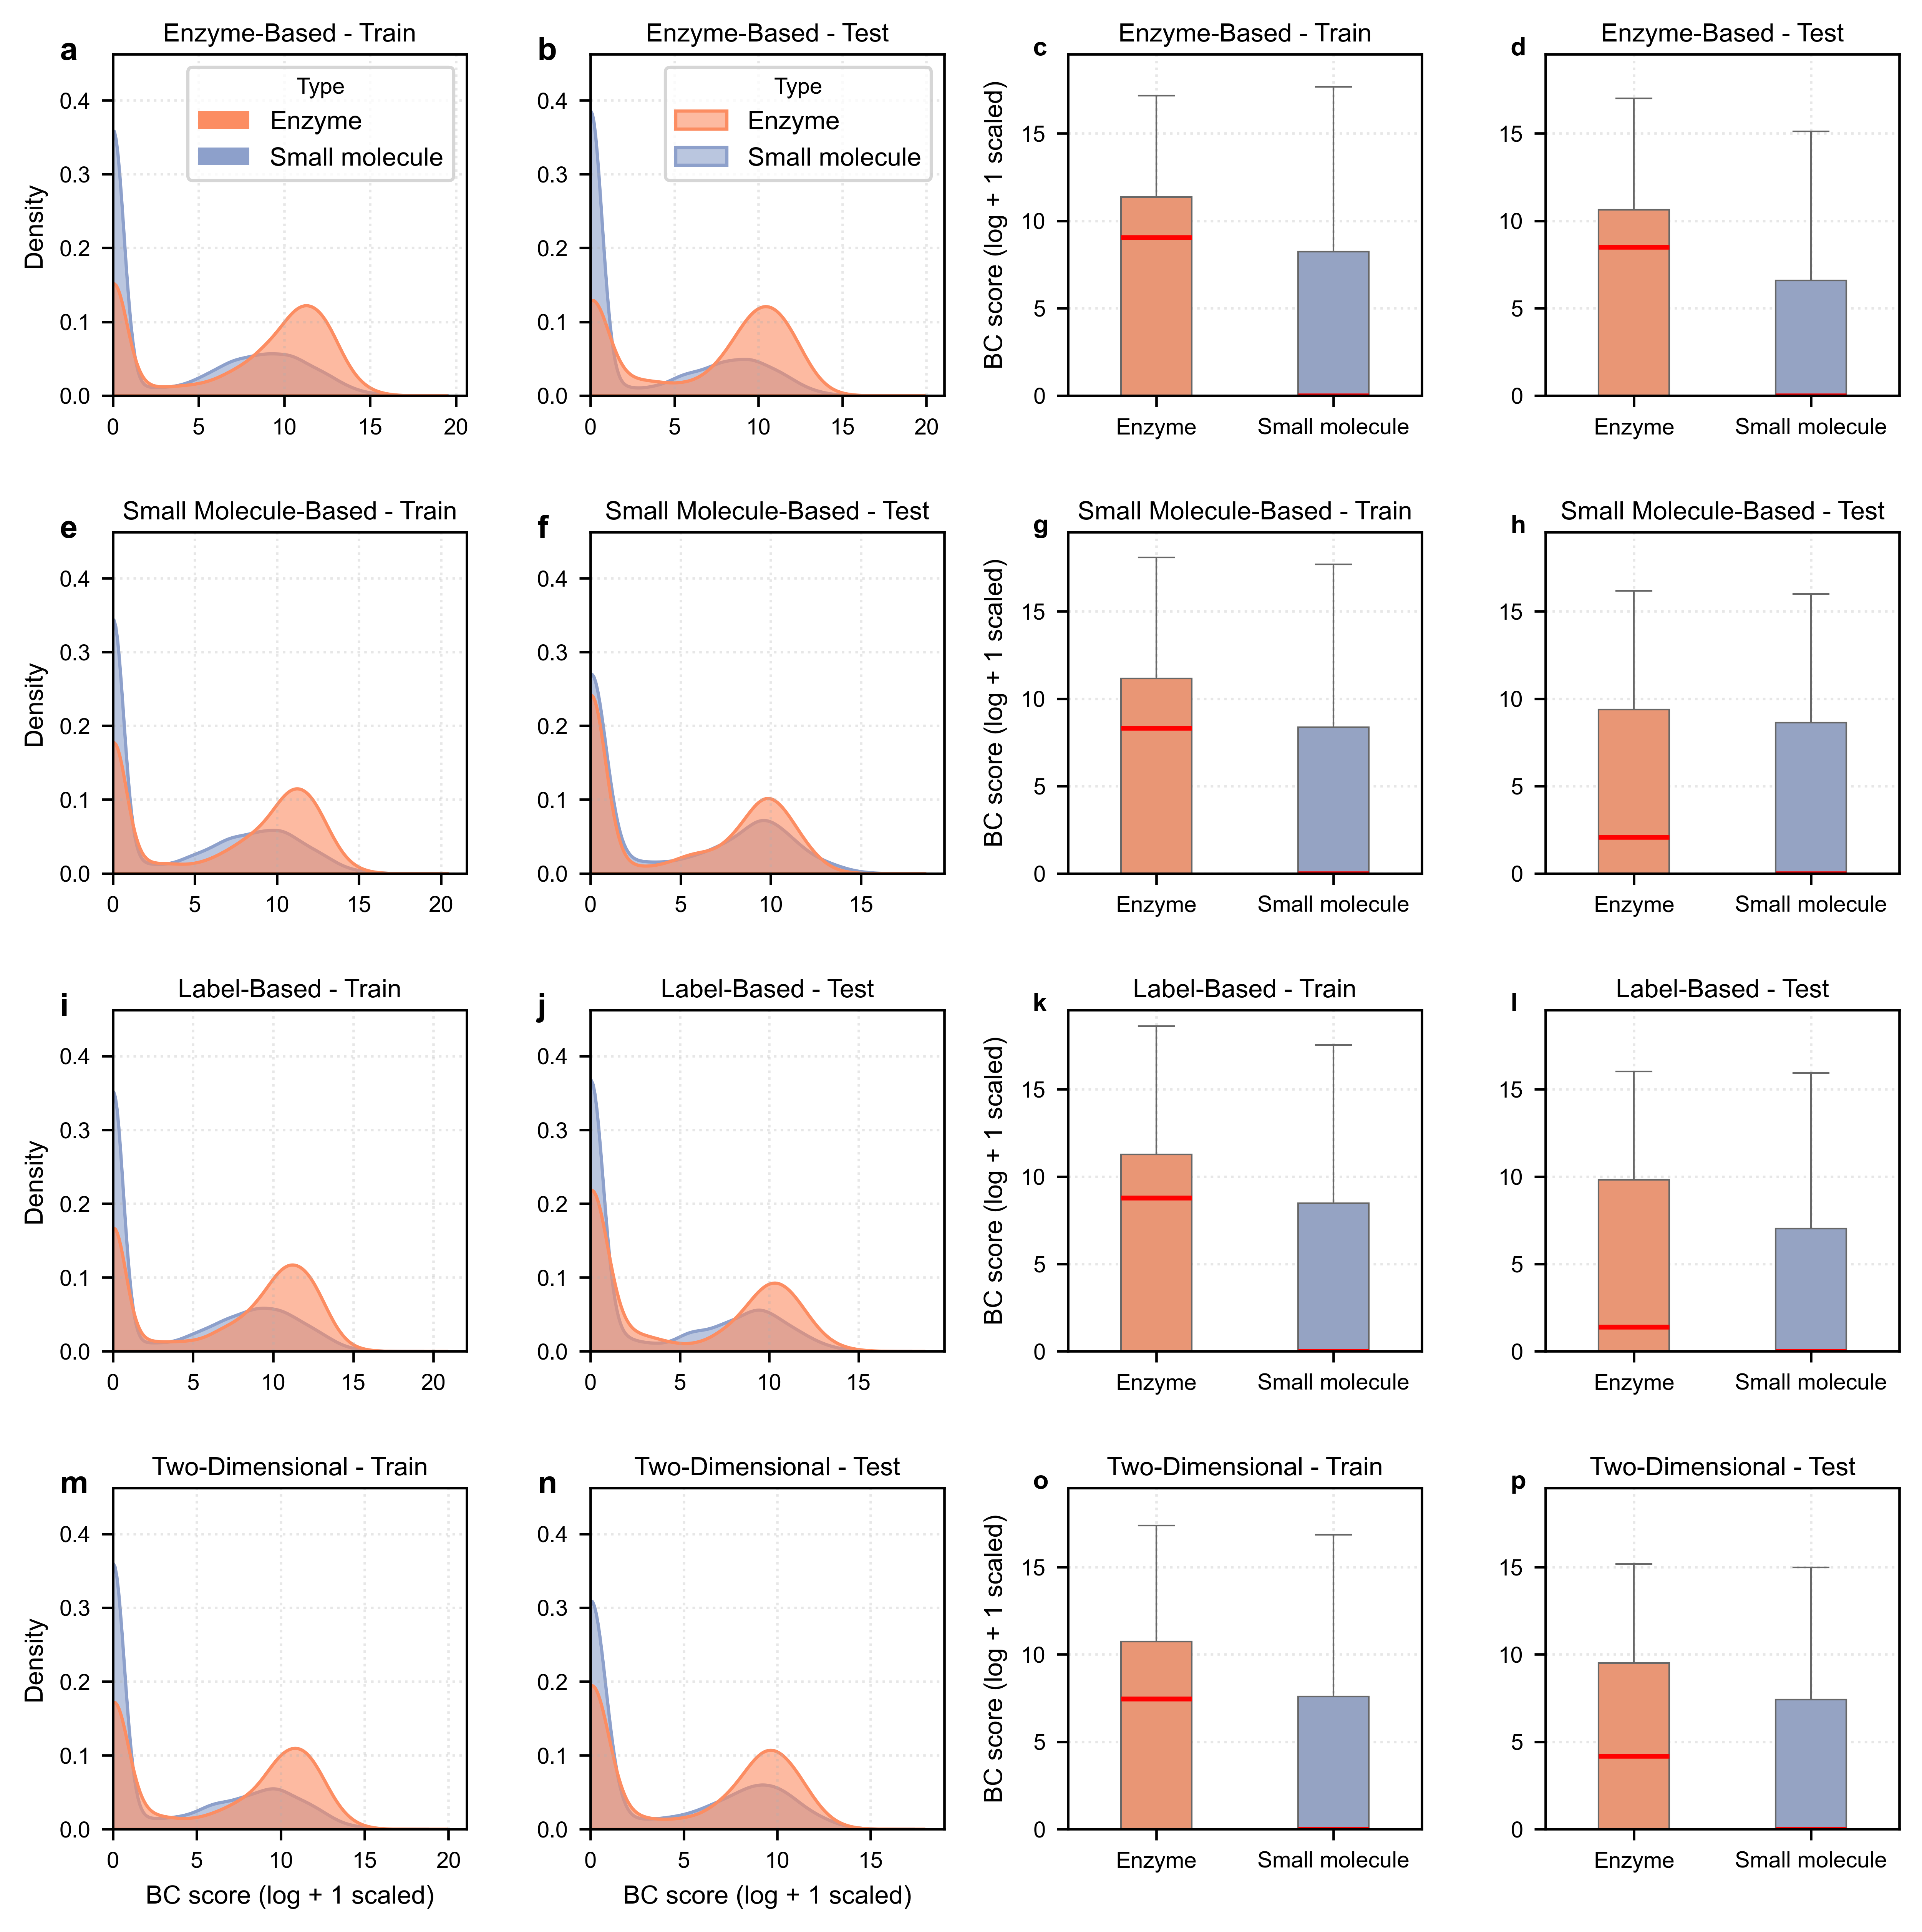

Combined analysis figure saved to: /Users/vahidatabaigi/EMMA/code/../data/final_dataset_analysis/Betweenness_analysis_combined.pdf


In [3]:
CURRENT_DIR = Path(os.getcwd())
OUTPUT_DIR = join(CURRENT_DIR, "..", "data", "final_dataset_analysis")
plot_betweenness_degrees(OUTPUT_DIR, metric="Betweenness")

# Binding distribution and average betweenness plot

In [3]:
CURRENT_DIR = Path(os.getcwd())
OUTPUT_DIR = CURRENT_DIR / ".." / "data" /"final_dataset_analysis"
# output_path = OUTPUT_DIR / "final_dataset_binding_venn_with_betweenness.png"
output_path = OUTPUT_DIR / "final_dataset_binding_venn_with_betweenness.pdf"
final_dataset = pd.read_pickle(CURRENT_DIR / ".." / "data" / "processed_data" / "Final_Dataset.pkl")
final_dataset_BC = pd.read_csv(CURRENT_DIR /OUTPUT_DIR / "betweenness_values.csv")

In [4]:
plot_binding_distribution(final_dataset, final_dataset_BC, output_path)

Combined Venn diagram with betweenness saved to: /Users/vahidatabaigi/SIP3-2/code/../data/final_dataset_analysis/final_dataset_binding_venn_with_betweenness.pdf

=== SUMMARY TABLE ===
Subset                    Avg BC          Nodes with Data Total Nodes    
----------------------------------------------------------------------

ENZYMES:
non_substrate_only        4.870           1145            1145           
substrate_only            5.417           8104            8104           
inhibitor_only            4.268           1630            1630           
substrate_inhibitor       10.961          1567            1567           
non_substrate_substrate   11.024          406             406            
non_substrate_inhibitor   11.238          1534            1534           
all_three                 12.925          1266            1266           

MOLECULES:
non_substrate_only        3.119           12540           12518          
substrate_only            3.822           5586           

# EC analysis

In [11]:
train_C2 = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C2_2S.pkl"))
test_C2 =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C2_2S.pkl"))
train_C1e = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C1e_2S.pkl"))
test_C1e =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C1e_2S.pkl"))
train_C1f = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C1f_2S.pkl"))
test_C1f =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C1f_2S.pkl"))
train_C1 = pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "train_C1_2S.pkl"))
test_C1 =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "splits", "test_C1_2S.pkl"))
final_dataset =  pd.read_pickle(join(CURRENT_DIR, ".." ,"data", "processed_data", "Final_dataset.pkl"))

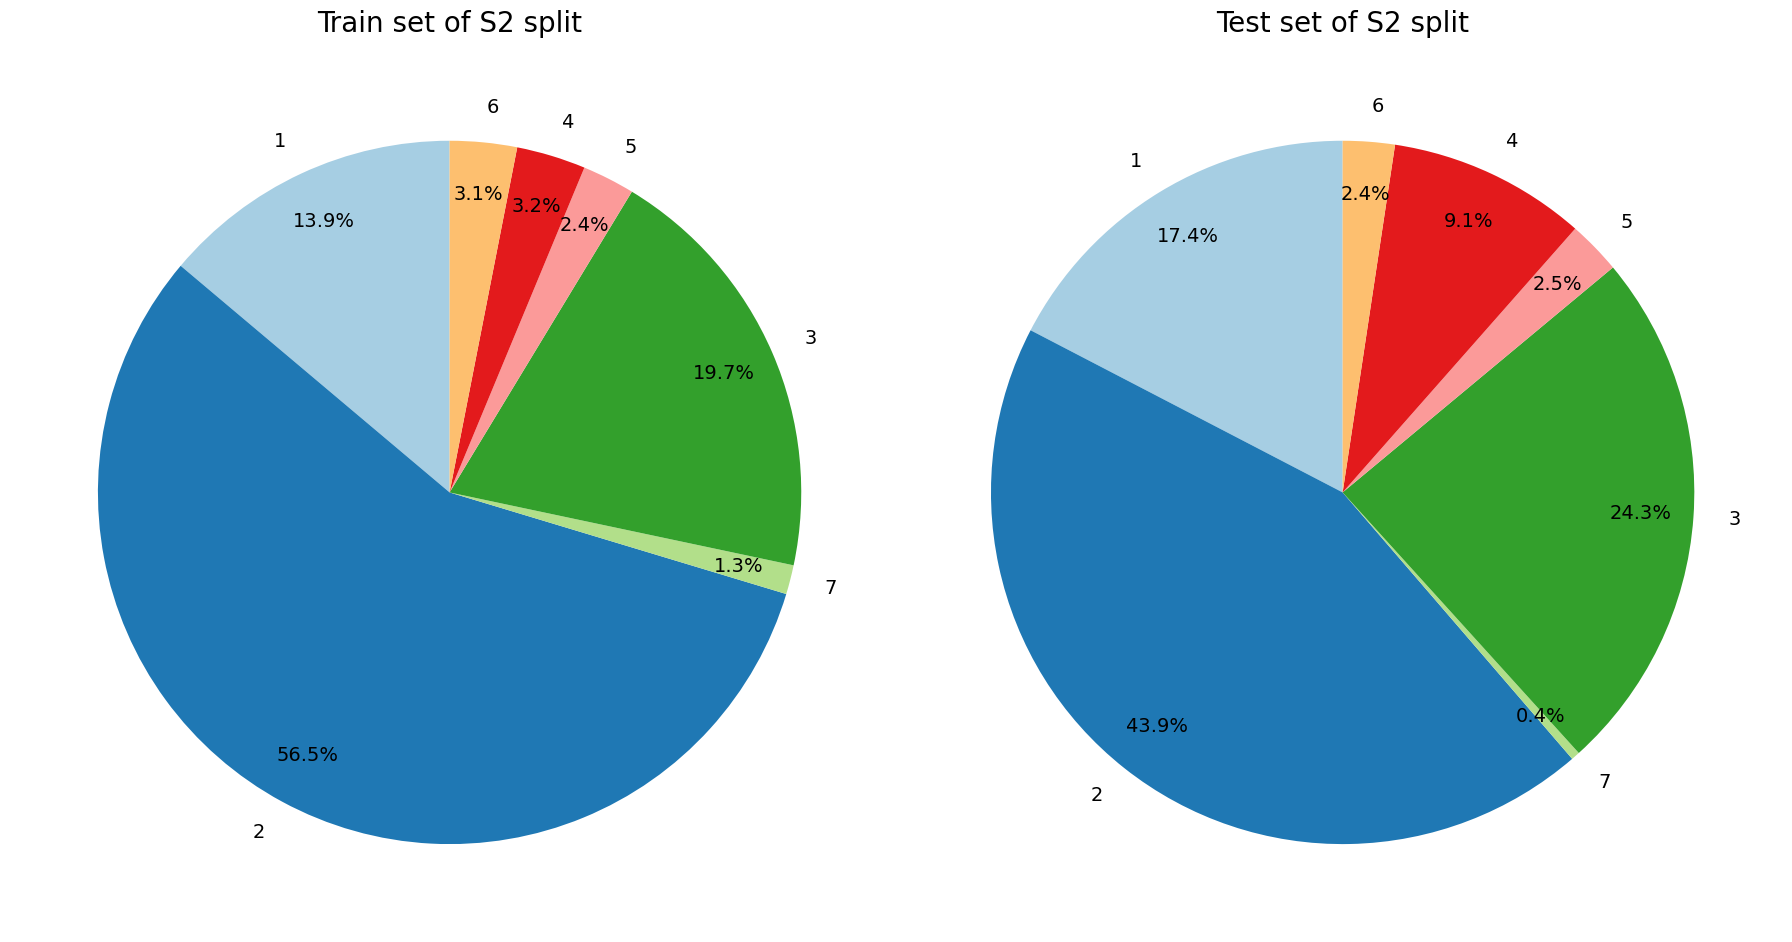

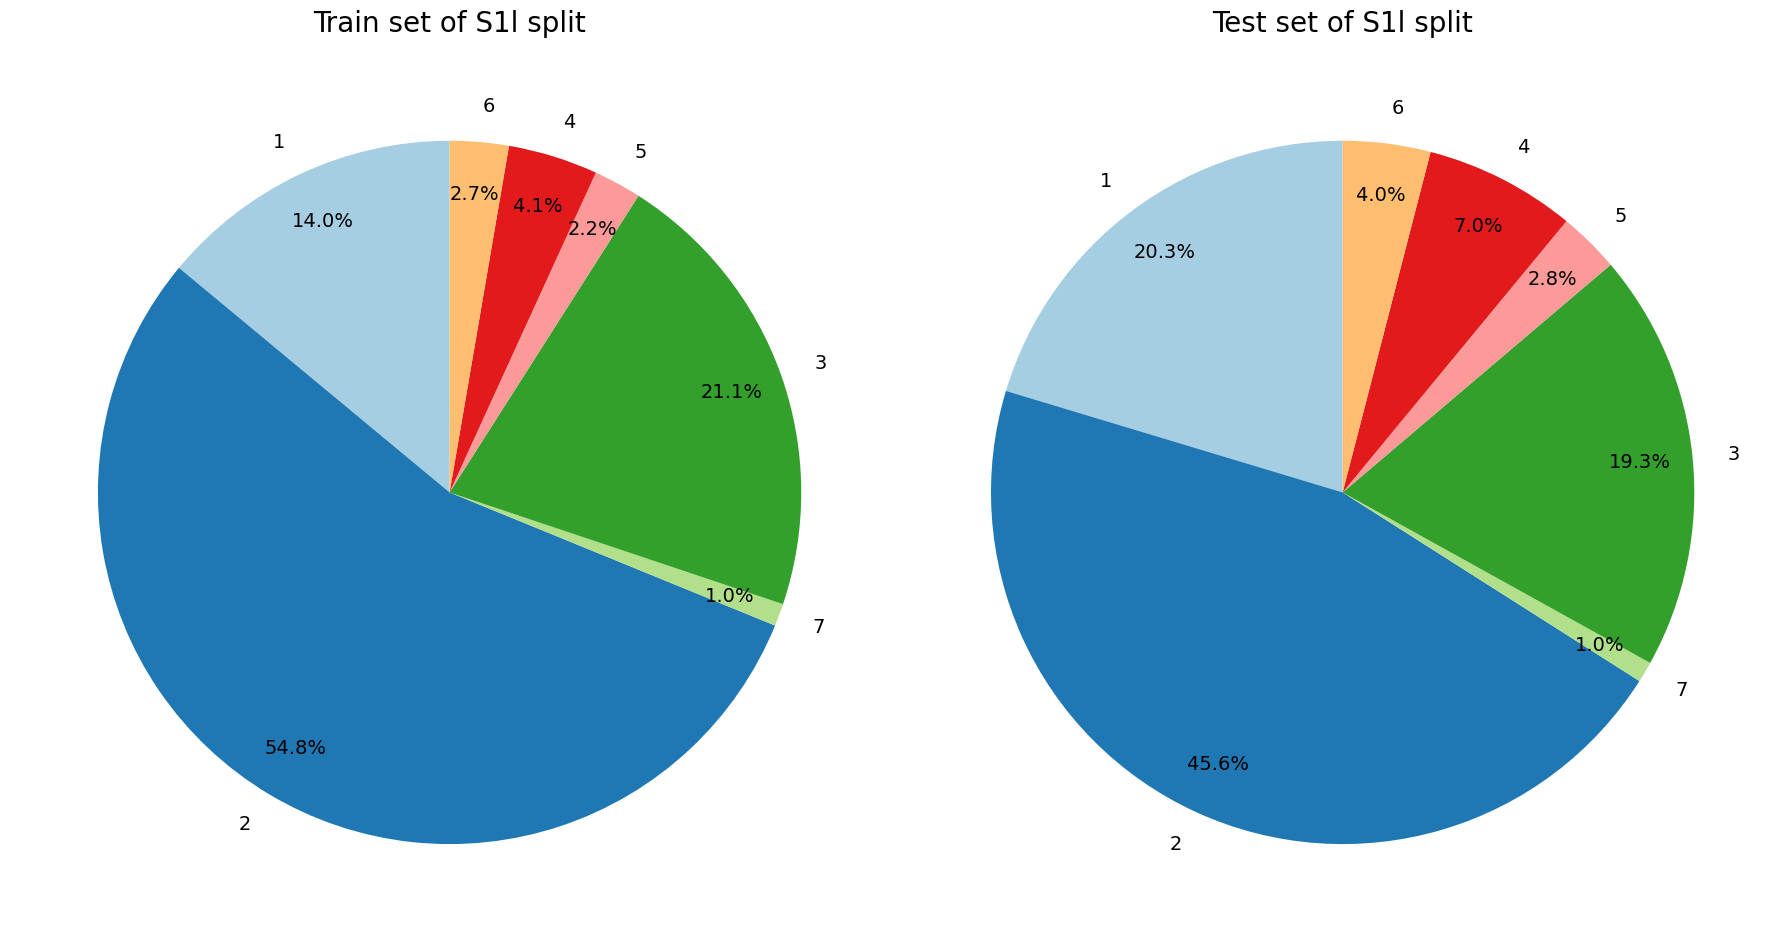

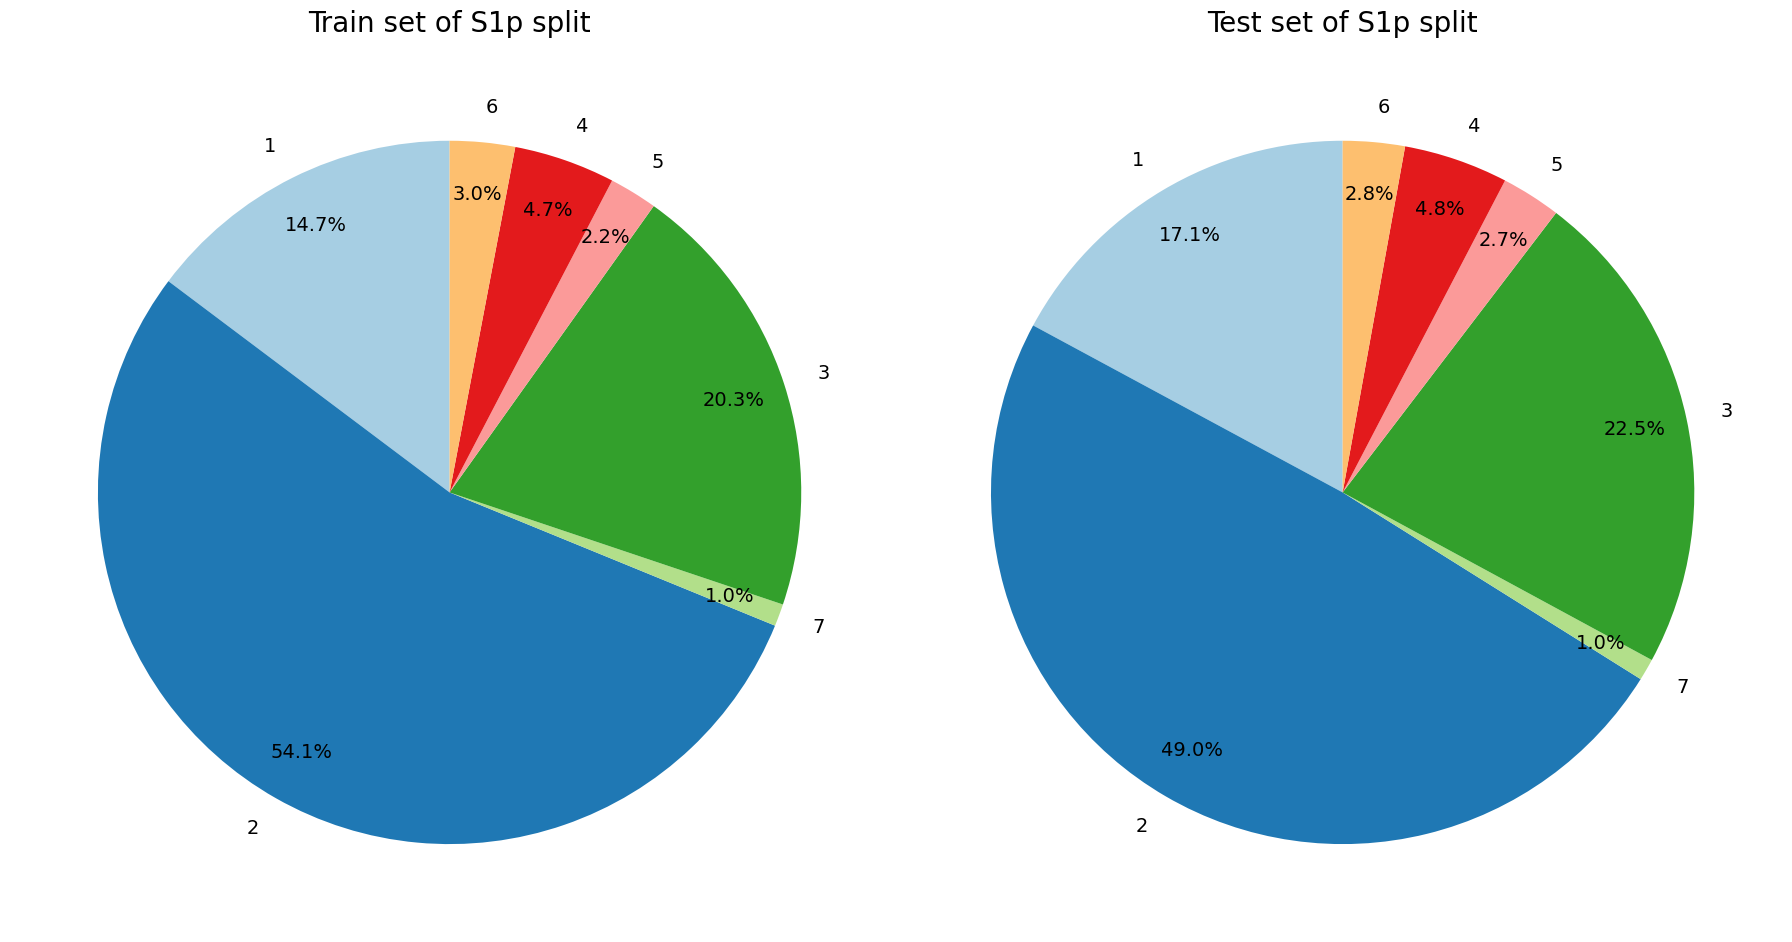

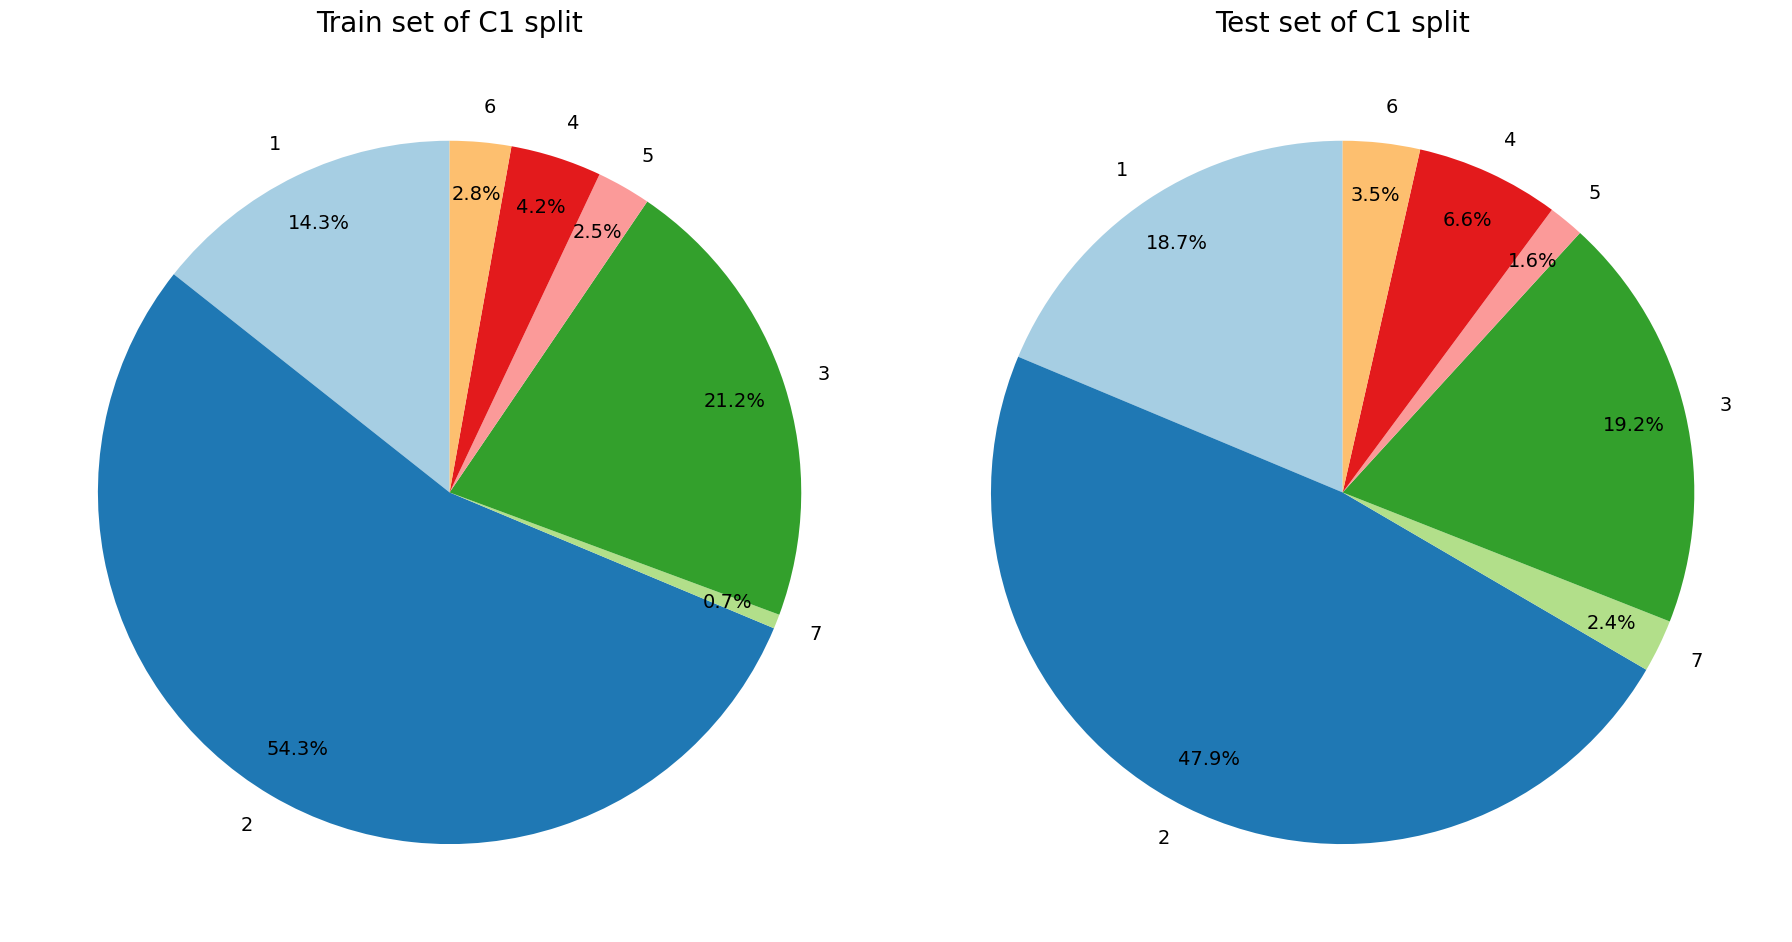

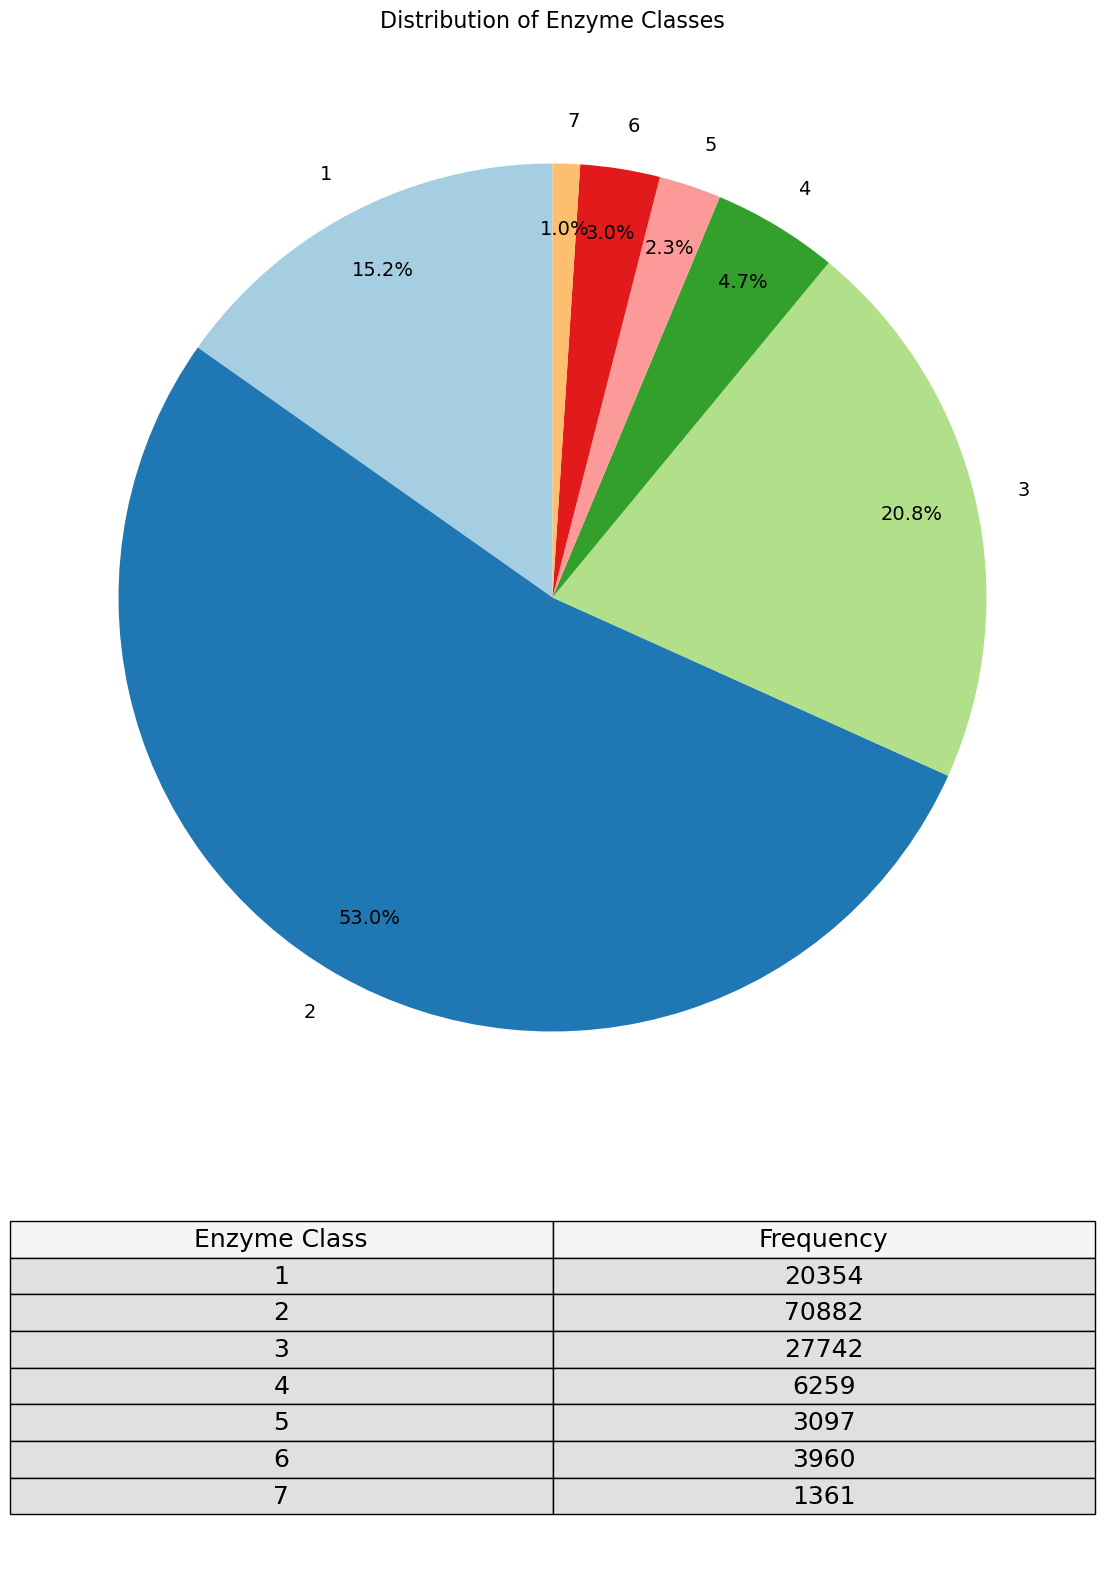

In [12]:
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C2-EC-ID.png")
ven_ec_v3(train_C2,test_C2,"S2",path)
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C1e-EC-ID.png")
ven_ec_v3(train_C1e,test_C1e,"S1l",path)
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C1f-EC-ID.png")
ven_ec_v3(train_C1f,test_C1f,"S1p",path)
path = join(CURRENT_DIR,"..","data","final_dataset_analysis","C1-EC-ID.png")
ven_ec_v3(train_C1,test_C1,"C1",path)
# add_legend=False

path = join(CURRENT_DIR,"..","data","final_dataset_analysis","finaldataset_EC-ID.png")
ven_ec(final_dataset,path)